## Customer Lifetime Value Modelling

### 0. Background


#### About Gifting.co
As online shopping becomes increasingly popular, mainly attributed to the convenience that customers get when purchasing and having the items delivered to their doorstep, more and more retailers are jumping onto the bandwagon to start their own businesses online. 

**Gifting.co** is a UK-based registered online retailer without any physical store presence. The company sells mainly unique all-occasion giftware, and many of its customers are wholesalers who will purchase the items in bulk and sell them to smaller-sized retailers. 


#### Problem Statement
With the heightened competition in the online retail business, Gifting.co wants to gain better visibility on its sales forecast in the next 12 months. To do so, it is keen to understand the customer lifecycle, i.e. **predicting the Customer Lifetime Value (CLV)**. 


#### Diving into Customer Lifetime Value (CLV)

CLV refers to the total monetary value of transactions or purchases made by customers with the company over their entire lifetime, in which lifetime is denoted by the time period from which customers make their first purchases to before they move to the company's competitors (Source: [Analytics Vidhya (July 2022)](https://www.analyticsvidhya.com/blog/2020/10/a-definitive-guide-for-predicting-customer-lifetime-value-clv/)). 

The general formula for computing CLV is: **CLV = [ (Average Sales x Purchase Frequency) / Churn ] x Profit Margin**

where:
- *Average Sales = Total Sales / Total No. of Orders*
- *Purchase Frequency = Total No. of Orders / Total Unique Customers*
- *Retention Rate = Total No. of Orders greater than 1 / Total Unique Customers*
- *Churn = 1 - Retention Rate*
- *Profit Margin = dependent on business context*

There are two main approaches for determining CLV:
- Historical Approach: 
    1. **Aggregate model**
        - Calculate the CLV using the average revenue per customer based on past transactions
        - Provides a single value for CLV for all customers
    2. **Cohort model**
        - Segment customers into different cohorts based on features such as transaction date, items, etc. 
        - Calculate the average revenue per cohort, thus arriving at CLV value for each cohort
- Predictive Approach: 
    1. **Machine Learning model**
        - Use regression techniques to fit on past data to predict the CLV 
    2. **Probabilistic model**
        - Fit a probability distribution to the data
        - Estimate the future count of transactions and monetary value for each transaction
    
    
#### About the Dataset
The dataset contains transactions that have occurred between 1 Dec 2009 to 9 Dec 2011 at Gifting.co.

|Field|Data Type|Description|
|-----|---------|-----------|
|Invoice|object|Invoice number; a 6-digit integral number uniquely assigned to each transaction; if code starts with letter 'c', it indicates a cancellation|
|StockCode|object|Product (item) code; a 5-digit integral number uniquely assigned to each distinct product|
|Description|object|Product (item) name|
|Quantity|integer|Quantity of each product (item) per transaction|
|InvoiceDate|object|Invoice date and time; the day and time when a transaction was generated|
|Price|float|Unit price; product price per unit in sterling|
|Customer ID|float|Customer number; a 5-digit integral number uniquely assigned to each customer|
|Country|object|Country name; the name of the country where a customer resides|

Source: [Kaggle: Online Retail II UCI](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci)

### 1. Introduction

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('whitegrid')
warnings.simplefilter(action='ignore',category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# import data
df = pd.read_csv('../data/raw/online_retail_II.csv')

# view top 5 rows
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### 2. Exploratory Data Analysis

#### 2.1. General trends

In [3]:
# view shape
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset.')

There are 1067371 rows and 8 columns in the dataset.


In [4]:
# check if there are duplicated rows
num_duplicates = df.duplicated().sum()
print(f'There are {num_duplicates} duplicated rows in the dataset.')

There are 34335 duplicated rows in the dataset.


In [5]:
# view data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [6]:
# view null values
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Based on the above checks, it can be observed that: 
- The data types of the fields include object (text), integer and float.
- The `InvoiceDate` field does not have the correct data type, i.e. it should be 'datetime' for `InvoiceDate`.
- Null values exist in the `Description` and `Customer ID` fields.
    - For rows with missing `Customer ID`, they may be dropped as they cannot be traced to particular customers.

Let's first convert the `InvoiceDate` to the right data type.

In [7]:
# change 'InvoiceDate' data type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# view data type again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


Now that we've converted `InvoiceDate` to the right data type, let's find out the number of unique values in each column.

In [8]:
# count no. of unique values
df.nunique()

Invoice        53628
StockCode       5305
Description     5698
Quantity        1057
InvoiceDate    47635
Price           2807
Customer ID     5942
Country           43
dtype: int64

It is interesting to note that: 
- There are 5,305 unique `StockCode` values, but there are more unique `Description` - 5,698 values. Ideally, each `Description` should have its own `StockCode`, unless there are some modifications made to the `Description` for the same `StockCode`.
- There are 5,942 unique `Customer ID`, and these customers reside across 43 unique `Country`.
- 5,942 unique customers contribute to a total of 53,628 transactions denoted by the unique `Invoice` values, indicating that each customer may have made an average of 9 transactions.
    - Note that some of these transactions may represent cancellation.
    
    
Let's view the numerical description for the data fields with 'integer' and 'float' data types.

In [9]:
# view numerical description
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


Referring to the numerical description, it can be observed that: 
- Negative values exist for both `Quantity` and `Price`.
- The minimum and maximum values for `Quantity` match when absolute terms are applied - this may represent transactions that have been cancelled.
- However, the minimum and maximum values for `Price` do not match when absolute terms are applied.


Let's view some of these transactions with negative `Quantity` and `Price`.

In [10]:
# view rows with negative 'Quantity'
df[df['Quantity']<0].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


#### 2.2. Checking on cancelled transactions

Based on the rows with negative `Quantity`, it is likely that the transactions are cancelled. 

Let's validate this by checking if the `Invoice` values begin with a 'C'.

In [11]:
# create new column to indicate 'cancelled_trans'
df['cancelled_trans'] = df['Invoice'].str.startswith('C',na=False)

# view top 5 rows
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,False
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,False
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,False


In [12]:
# view count of unique values in 'cancelled_trans'
print(df['cancelled_trans'].value_counts())
print()
print(df['cancelled_trans'].value_counts(normalize=True))

False    1047877
True       19494
Name: cancelled_trans, dtype: int64

False    0.981736
True     0.018264
Name: cancelled_trans, dtype: float64


In [13]:
# view rows with 1) 'cancelled_trans'==True and 2) 'Quantity'>0
df[(df['cancelled_trans']==True)&(df['Quantity']>0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom,True


Based on these checks, it can be observed that: 
- There are 19,494 transactions that have been cancelled - this makes up 1.8% of total transactions.
- Among the cancelled transactions, only one transaction has quantity greater than 0.
    - Based on the `Description`, this may be a manual adjustment done by the staff for exceptional cases.
- Cancelled transactions will need to be factored into consideration when computing the customer lifetime value.

In [14]:
# view rows with negative 'Price'
df[df['Price']<0].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom,False
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom,False
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom,False
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,False
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,False


For rows with negative `Price`, it seems that there are missing values in `Customer ID`. Besides, the `StockCode` does not follow the convention of 5-digit integral number, while the `Description` suggests certain exceptional handling done by the staff. 

Let's look into the variation on `StockCode`.

#### 2.3 Checking on `StockCode` variation

In [15]:
# create new column to count length of 'StockCode'
df['stockcode_length'] = df['StockCode'].astype(str).map(len)

# view top 5 rows
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans,stockcode_length
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,False,5
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,6
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,6
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,False,5
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,False,5


In [16]:
# view count of unique values in 'stockcode_length'
print(df['stockcode_length'].value_counts())
print()
print(df['stockcode_length'].value_counts(normalize=True))

5     932385
6     127590
4       2158
1       1713
3       1446
7       1393
2        283
12       202
8        127
9         74
Name: stockcode_length, dtype: int64

5     0.873534
6     0.119537
4     0.002022
1     0.001605
3     0.001355
7     0.001305
2     0.000265
12    0.000189
8     0.000119
9     0.000069
Name: stockcode_length, dtype: float64


It is interesting to note that: 
- 87.4% and 12.0% of the transactions have `StockCode` values that are of 5 to 6 in character length.
    - These transactions likely feature actual products sold by the company. 
- There are `StockCode` values with minimum character length of 1 and up to a maximum of 12.
    - These `StockCode` values seem out of the norm, and may need to be investigated further. 
    
Let's look into rows with a character length of 1 in `stockcode_length`.

In [17]:
# view rows with 'stockcode_length'==1
df[df['stockcode_length']==1]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans,stockcode_length
735,C489535,D,Discount,-1,2009-12-01 12:11:00,9.00,15299.0,United Kingdom,True,1
736,C489535,D,Discount,-1,2009-12-01 12:11:00,19.00,15299.0,United Kingdom,True,1
2697,489609,M,Manual,1,2009-12-01 14:50:00,4.00,NaN,United Kingdom,False,1
3053,C489651,M,Manual,-1,2009-12-01 16:48:00,5.10,17804.0,United Kingdom,True,1
5897,C489859,M,Manual,-1,2009-12-02 14:45:00,69.57,NaN,United Kingdom,True,1
...,...,...,...,...,...,...,...,...,...,...
1056893,580956,M,Manual,4,2011-12-06 14:23:00,1.25,17841.0,United Kingdom,False,1
1058543,C581009,M,Manual,-1,2011-12-07 09:15:00,125.00,16971.0,United Kingdom,True,1
1059769,C581145,M,Manual,-1,2011-12-07 13:48:00,9.95,17490.0,United Kingdom,True,1
1063782,581405,M,Manual,3,2011-12-08 13:50:00,0.42,13521.0,United Kingdom,False,1


In [18]:
# create pivot table containing count of 'StockCode' and 'Description' values for rows with 'stockcode_length'==1
df_pivot_1 = pd.pivot_table(df[df['stockcode_length']==1], 
                          values='Invoice', 
                          index='Description', 
                          columns='StockCode', 
                          aggfunc='count')

# view pivot table
df_pivot_1

StockCode,B,D,M,S,m
Description,,,,,
Adjust bad debt,6.0,NaN,NaN,NaN,NaN
Discount,NaN,177.0,NaN,NaN,NaN
Manual,NaN,NaN,1421.0,NaN,5.0
SAMPLES,NaN,NaN,NaN,104.0,NaN


Looking at the pivot table featuring count of `StockCode` and `Description`, it can be noted that:
- The company uses a variety of `StockCode` values to represent different actions taken for a particular item and customer.
- There may be some data entry errors when keying in the `StockCode`, i.e. use of 'M' and 'm' for 'Manual' transactions, and these errors may need to be corrected.


Let's look into rows with a character length of 12 in `stockcode_length`.

In [19]:
# view rows with 'stockcode_length'==12
df[df['stockcode_length']==12]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans,stockcode_length
18410,C490943,BANK CHARGES,Bank Charges,-1,2009-12-08 14:08:00,15.00,16703.0,United Kingdom,True,12
18466,490948,BANK CHARGES,Bank Charges,1,2009-12-08 14:29:00,15.00,16805.0,United Kingdom,False,12
30620,491968,gift_0001_80,NaN,2,2009-12-14 17:56:00,0.00,NaN,United Kingdom,False,12
31079,491969,gift_0001_80,Dotcomgiftshop Gift Voucher £80.00,1,2009-12-14 17:57:00,69.56,NaN,United Kingdom,False,12
32048,491971,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,2,2009-12-14 18:37:00,17.39,NaN,United Kingdom,False,12
...,...,...,...,...,...,...,...,...,...,...
1006613,C577342,BANK CHARGES,Bank Charges,-1,2011-11-18 15:11:00,490.06,NaN,United Kingdom,True,12
1006614,C577343,BANK CHARGES,Bank Charges,-1,2011-11-18 15:13:00,27.21,NaN,United Kingdom,True,12
1031818,579137,BANK CHARGES,Bank Charges,1,2011-11-28 12:51:00,15.00,14704.0,United Kingdom,False,12
1059469,581127,BANK CHARGES,Bank Charges,1,2011-12-07 12:45:00,15.00,16271.0,United Kingdom,False,12


In [20]:
# create pivot table containing count of 'StockCode' and 'Description' values for rows with 'stockcode_length'==12
df_pivot_12 = pd.pivot_table(df[df['stockcode_length']==12],
                             values='Invoice', 
                             index='Description', 
                             columns='StockCode', 
                             aggfunc='count')

# view pivot table
df_pivot_12

StockCode,BANK CHARGES,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,gift_0001_70,gift_0001_80
Description,,,,,,,,
Bank Charges,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bank Charges,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dotcomgiftshop Gift Voucher £10.00,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
Dotcomgiftshop Gift Voucher £20.00,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN
Dotcomgiftshop Gift Voucher £30.00,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN
Dotcomgiftshop Gift Voucher £40.00,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
Dotcomgiftshop Gift Voucher £50.00,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
Dotcomgiftshop Gift Voucher £70.00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Dotcomgiftshop Gift Voucher £80.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


Similar to the earlier pivot table, the `Description` field may be subjected to data entry errors, i.e. both `Description` 'Dotcomgiftshop Gift Voucher £20.00' and 'to push order througha s stock was' are tied to the `StockCode` 'gift_0001_20'.

It is worthwile to note that some of these rows do not contain any `Customer ID`, thus they may be dropped subsequently when computing the customer lifetime value.

#### 2.4 Identifying customers with most frequent transactions and their demographics

In [21]:
# create a new df to exclude 'Customer ID' with nan values
customer_df = df[df['Customer ID'].notna()]

In [22]:
# identify top 20 customers with most frequent transactions
top20_customers = customer_df['Customer ID'].value_counts(ascending=False).reset_index(name='Customer ID').head(20)
top20_customers.columns = ['Customer ID', 'Count']
top20_customers

,Customer ID,Count
0,17841.0,13097
1,14911.0,11613
2,12748.0,7307
3,14606.0,6709
4,14096.0,5128
5,15311.0,4717
6,14156.0,4130
7,14646.0,3890
8,13089.0,3438
9,16549.0,3255


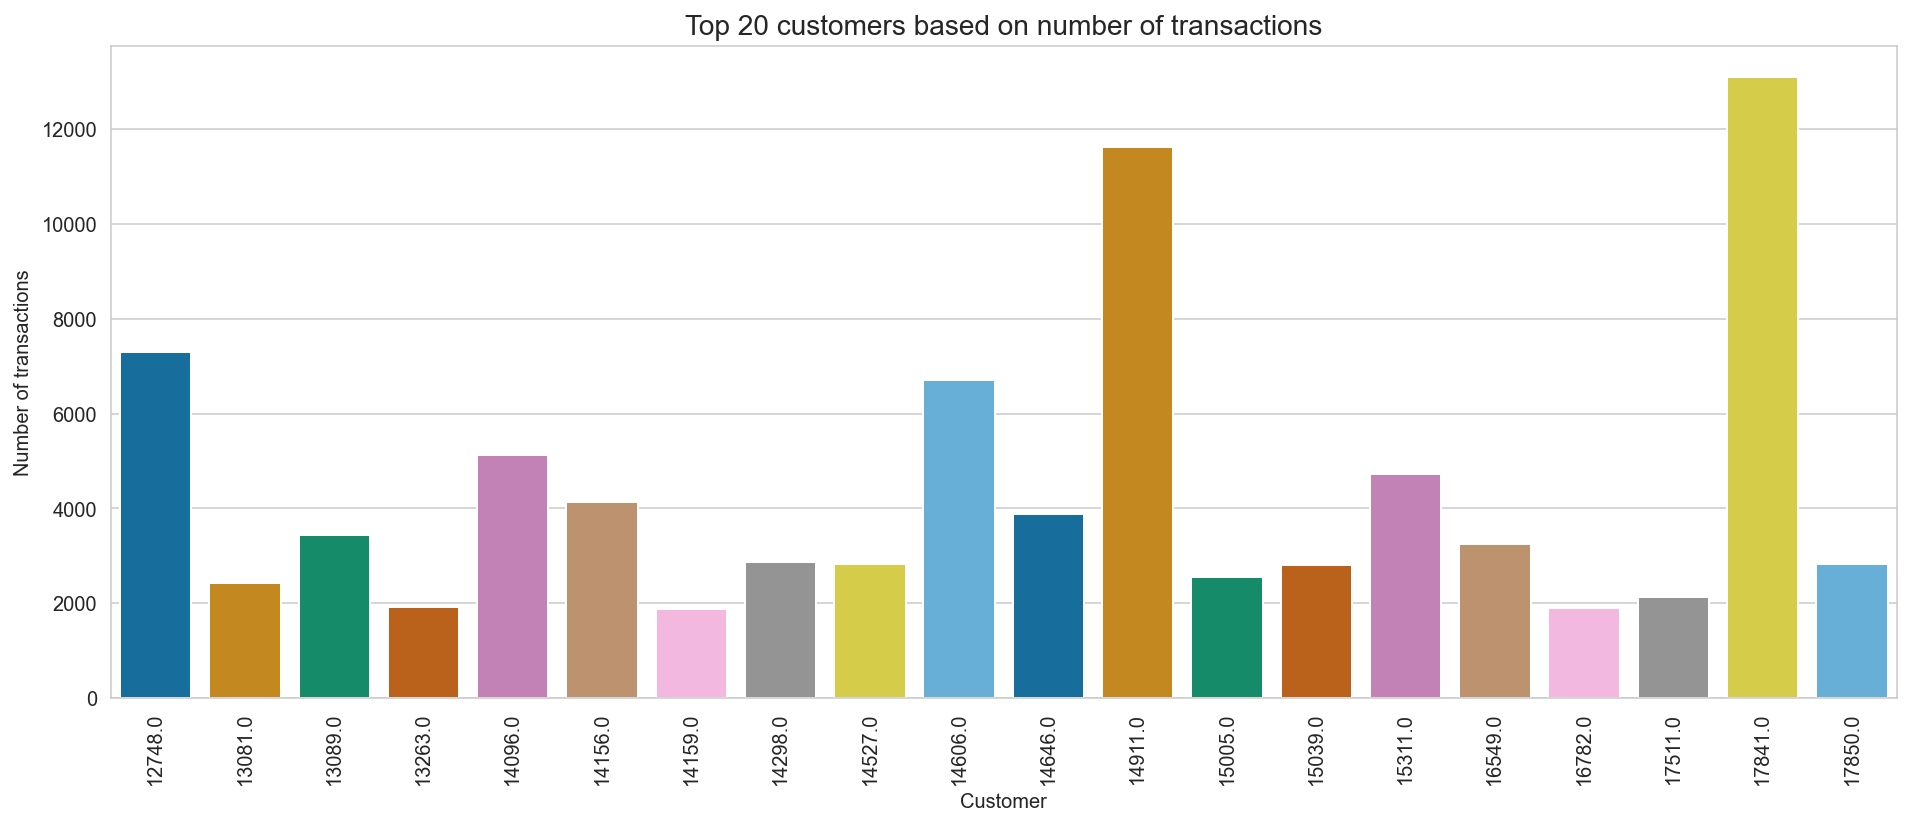

In [23]:
# plot top 20 customers
plt.figure(figsize=(16,6))
plt.title('Top 20 customers based on number of transactions', fontsize=14)
ax = sns.barplot(x='Customer ID', y='Count', data=top20_customers, palette='colorblind')
ax.set(xlabel='Customer', ylabel='Number of transactions')
ax.tick_params(axis='x', rotation=90)

It is interesting to note that the top customer has accumulated a total of 13,097 transactions, while the second customer has 11,613 transactions. The next few customers have transaction volumes below 10,000, which are still pretty impressive over a two-year period. 

In [24]:
# identify top 20 countries of customers with most frequent transactions
top20_countries = customer_df['Country'].value_counts(ascending=False).reset_index(name='Country').head(20)
top20_countries.columns = ['Country', 'Count']
top20_countries

,Country,Count
0,United Kingdom,741301
1,Germany,17624
2,EIRE,16195
3,France,14202
4,Netherlands,5140
5,Spain,3811
6,Belgium,3123
7,Switzerland,3064
8,Portugal,2504
9,Australia,1913


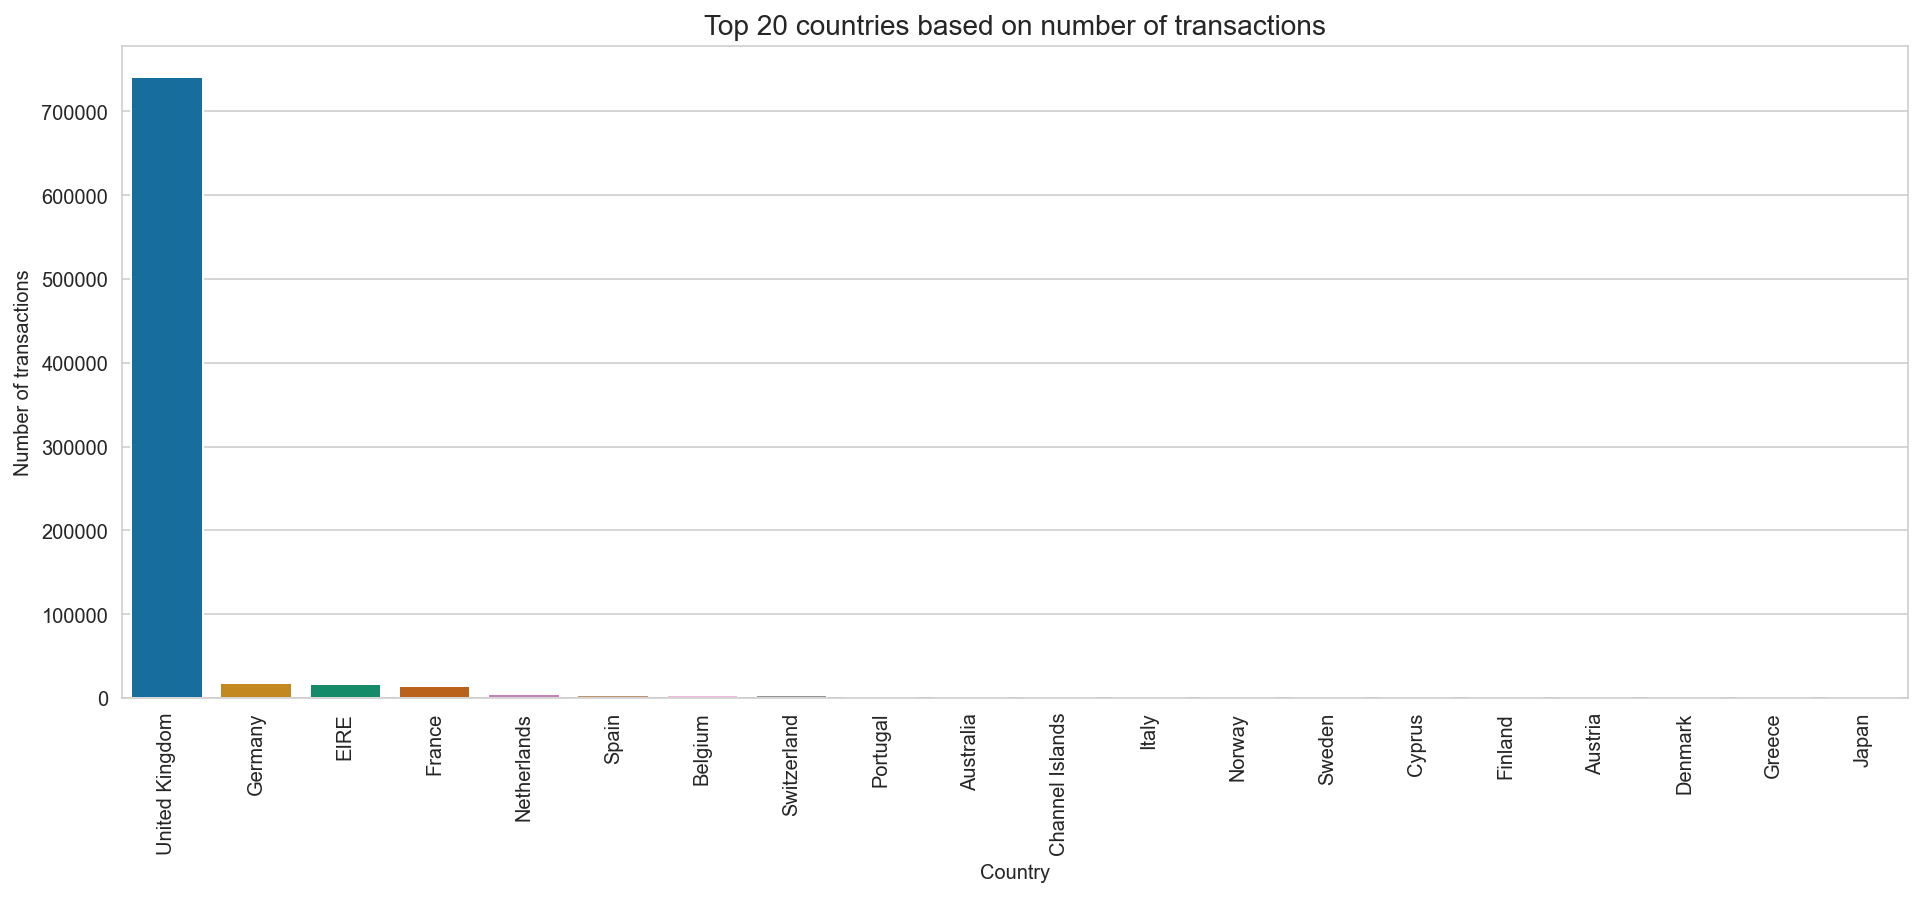

In [25]:
# plot top 20 countries
plt.figure(figsize=(16,6))
plt.title('Top 20 countries based on number of transactions', fontsize=14)
ax = sns.barplot(x='Country', y='Count', data=top20_countries, palette='colorblind')
ax.set(xlabel='Country', ylabel='Number of transactions')
ax.tick_params(axis='x', rotation=90)

Seems that most of the transactions occur within the United Kingdom, with some items being exported to Germany, Ireland (EIRE), followed by France. 

#### 2.5 Identifying top items purchased based on quantity

In [26]:
# create a new df with just 'Description' and 'Quantity'
items_df = df[['Description','Quantity']]

In [27]:
# group by 'Description' and sum up 'Quantity'
items_df = items_df.groupby('Description')['Quantity'].sum().reset_index(name='total_qty')

In [28]:
# identify top 20 items commonly purchased
top20_items = items_df.sort_values(by='total_qty',ascending=False).head(20)
top20_items

,Description,total_qty
5388,WORLD WAR 2 GLIDERS ASSTD DESIGNS,108545
5266,WHITE HANGING HEART T-LIGHT HOLDER,93050
328,ASSORTED COLOUR BIRD ORNAMENT,81306
2508,JUMBO BAG RED RETROSPOT,78090
801,BROCADE RING PURSE,70700
3204,PACK OF 60 PINK PAISLEY CAKE CASES,56575
168,60 TEATIME FAIRY CAKE CASES,54366
4706,SMALL POPCORN HOLDER,49616
3207,PACK OF 72 RETROSPOT CAKE CASES,49344
3206,PACK OF 72 RETRO SPOT CAKE CASES,46106


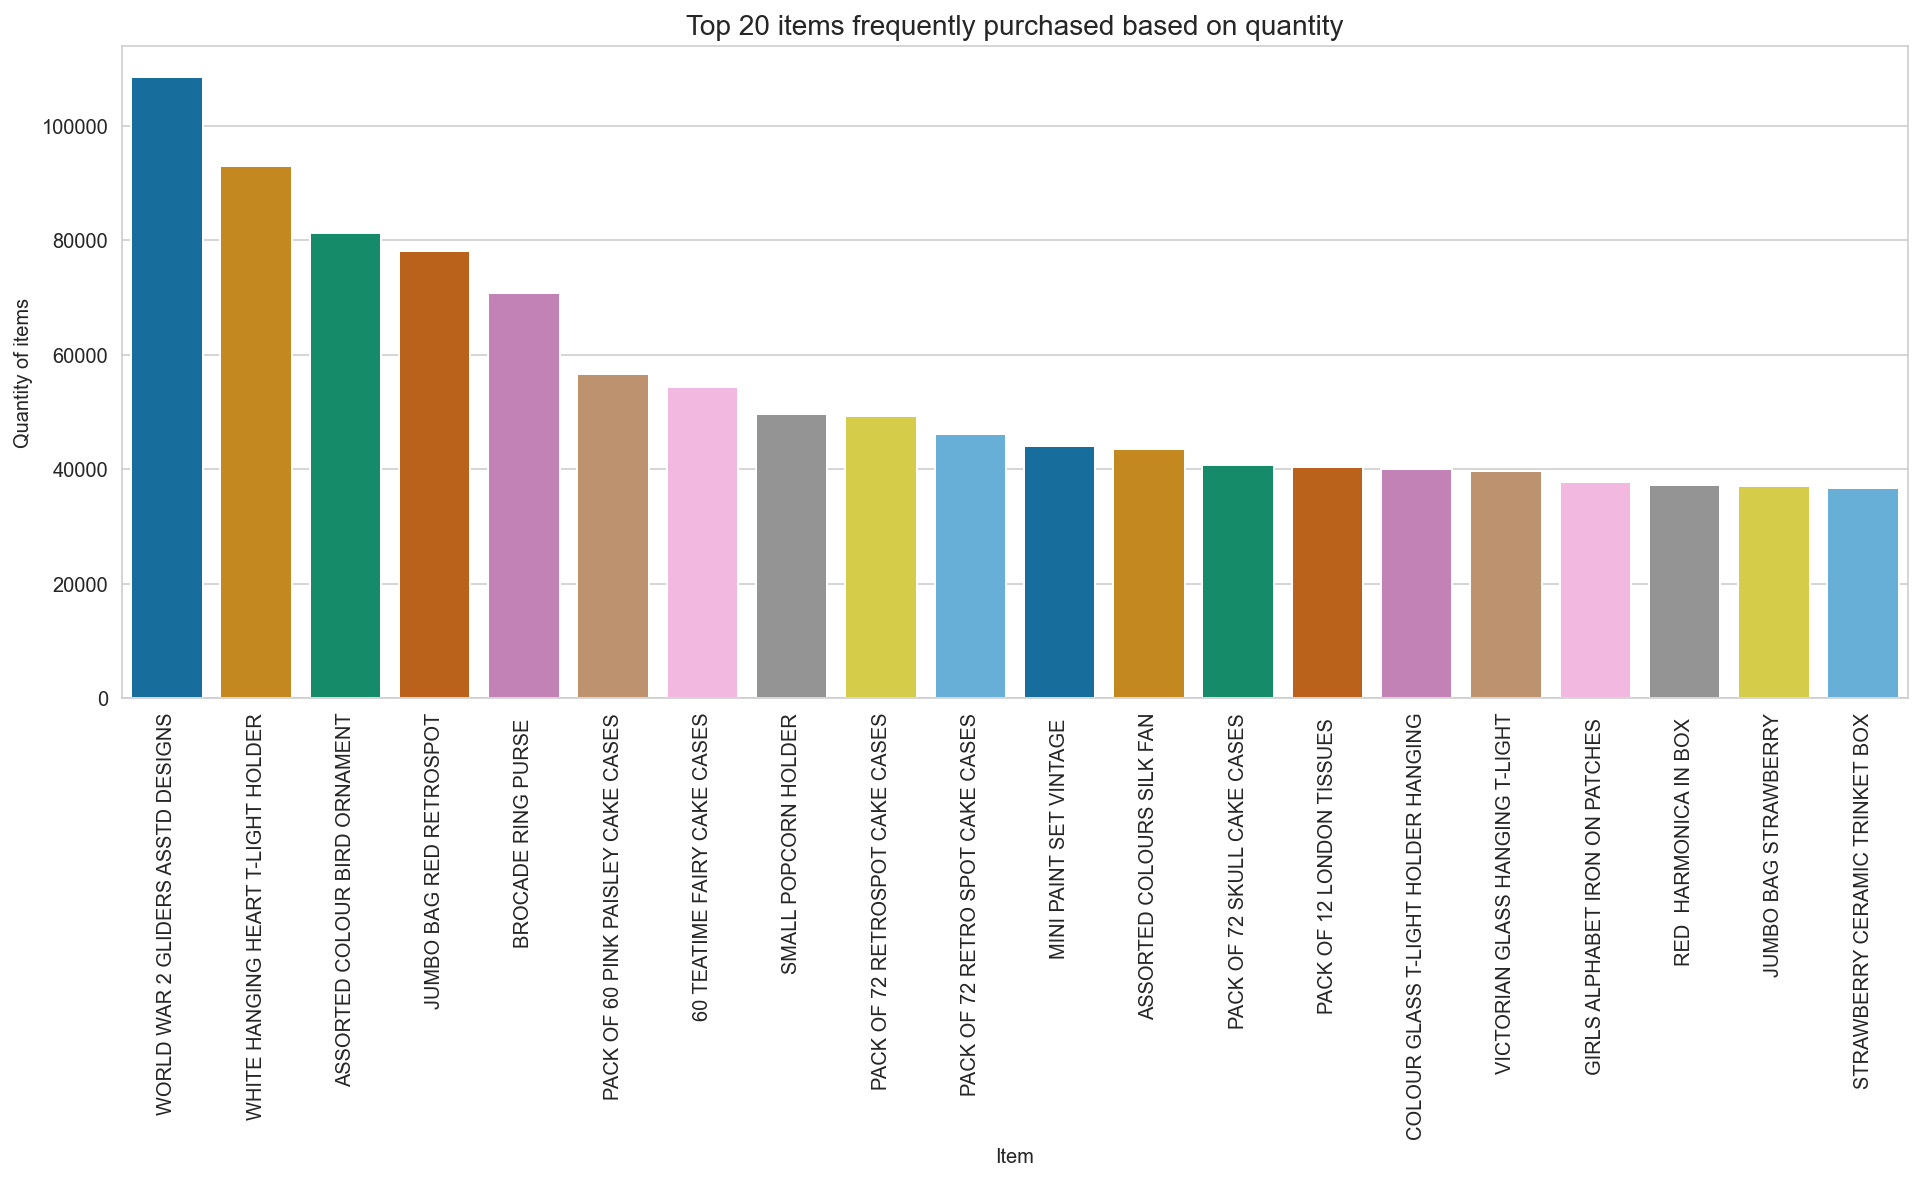

In [29]:
# plot top 20 items
plt.figure(figsize=(16,6))
plt.title('Top 20 items frequently purchased based on quantity', fontsize=14)
ax = sns.barplot(x='Description', y='total_qty', data=top20_items, palette='colorblind')
ax.set(xlabel='Item', ylabel='Quantity of items')
ax.tick_params(axis='x', rotation=90)

Based on the above plot, it seems that items such as the 'World War 2 Gliders Asstd Designs', 'White hanging heart T-light holder' and 'Assorted colour bird ornament' are the best selling products among the company's wholesale customers, used during special occasions and events. 

#### 2.6 Breaking down by day, date and time

In [30]:
# extract the date, month, year and hour from 'InvoiceDate'
df['invoicedate_only'] = df['InvoiceDate'].dt.date
df['invoice_day'] = df['InvoiceDate'].dt.day
df['invoice_month'] = df['InvoiceDate'].dt.month
df['invoice_year'] = df['InvoiceDate'].dt.year
df['invoice_hour'] = df['InvoiceDate'].apply(lambda x:x.hour)

# view top 5 rows
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans,stockcode_length,invoicedate_only,invoice_day,invoice_month,invoice_year,invoice_hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,False,5,2009-12-01,1,12,2009,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,6,2009-12-01,1,12,2009,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,6,2009-12-01,1,12,2009,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,False,5,2009-12-01,1,12,2009,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,False,5,2009-12-01,1,12,2009,7


In [31]:
# find the earliest and latest transaction date
min_trans_date = df['InvoiceDate'].min()
max_trans_date = df['InvoiceDate'].max()

print(f'The earliest transaction date is {min_trans_date}.')
print(f'The latest transaction date is {max_trans_date}.')

The earliest transaction date is 2009-12-01 07:45:00.
The latest transaction date is 2011-12-09 12:50:00.


In [32]:
# create a function to view distribution of transactions
def view_trans_dist(plot_x, plot_title, plot_xlabel):
    plt.figure(figsize=(16,6))
    plt.title(plot_title, fontsize=14)
    ax = sns.countplot(x=plot_x, data=df, palette='colorblind')
    ax.set(xlabel=plot_xlabel, ylabel='Number of transactions')  

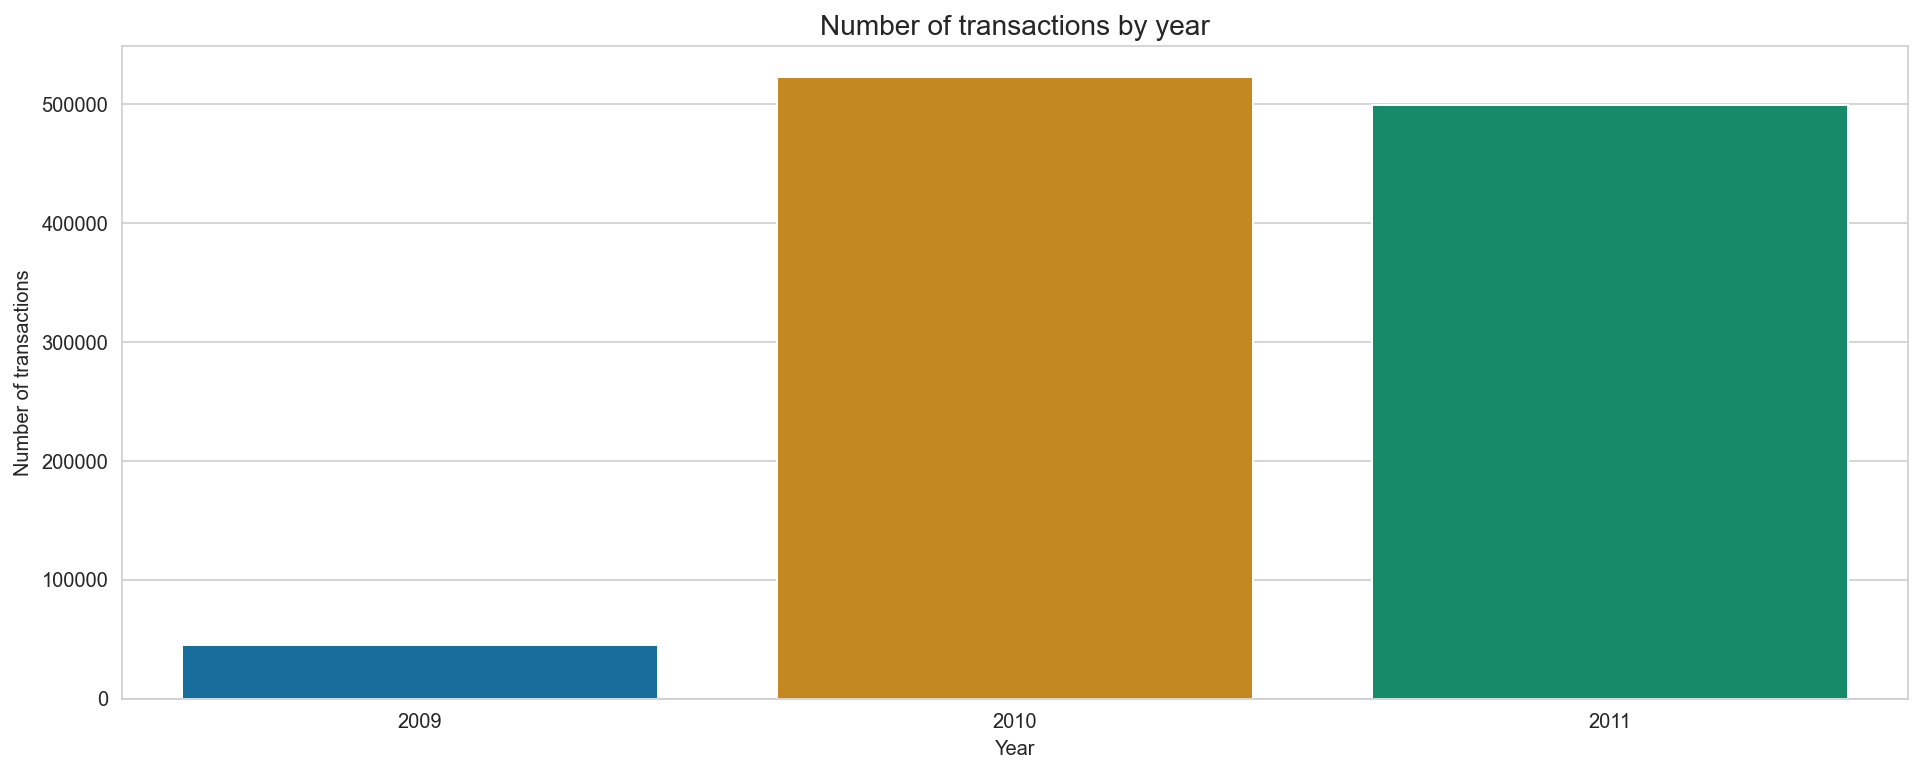

In [33]:
# view the distribution of transaction by 'invoice_year'
view_trans_dist(plot_x='invoice_year', plot_title='Number of transactions by year', plot_xlabel='Year')

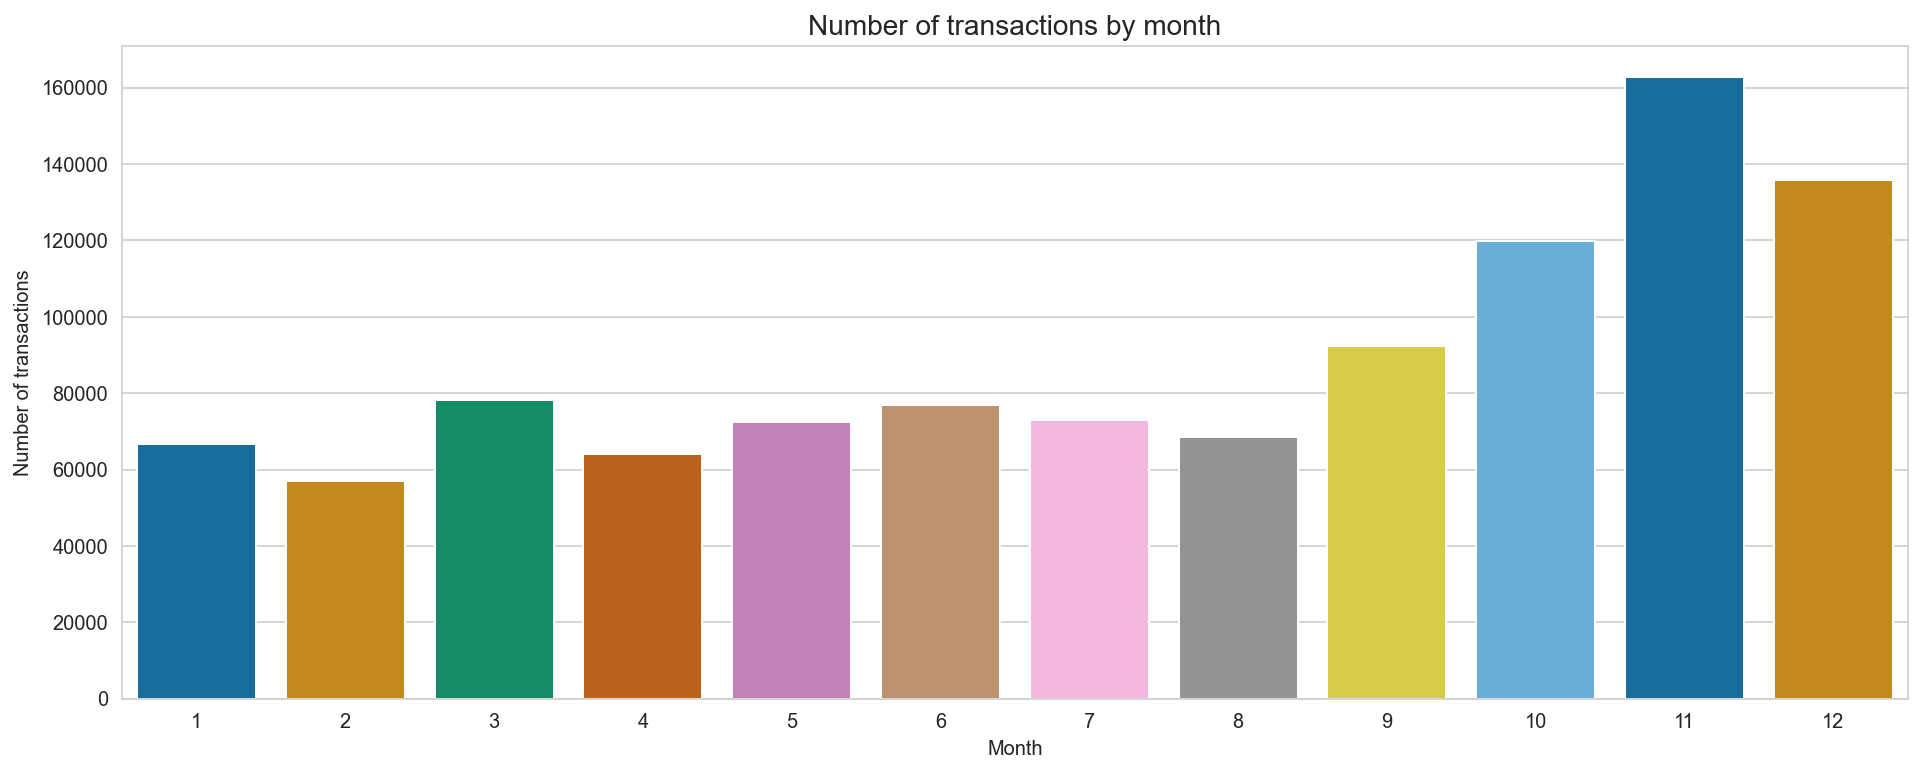

In [34]:
# view the distribution of transaction by 'invoice_month'
view_trans_dist(plot_x='invoice_month', plot_title='Number of transactions by month', plot_xlabel='Month')
#months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#ax.set_xticklabels(months)

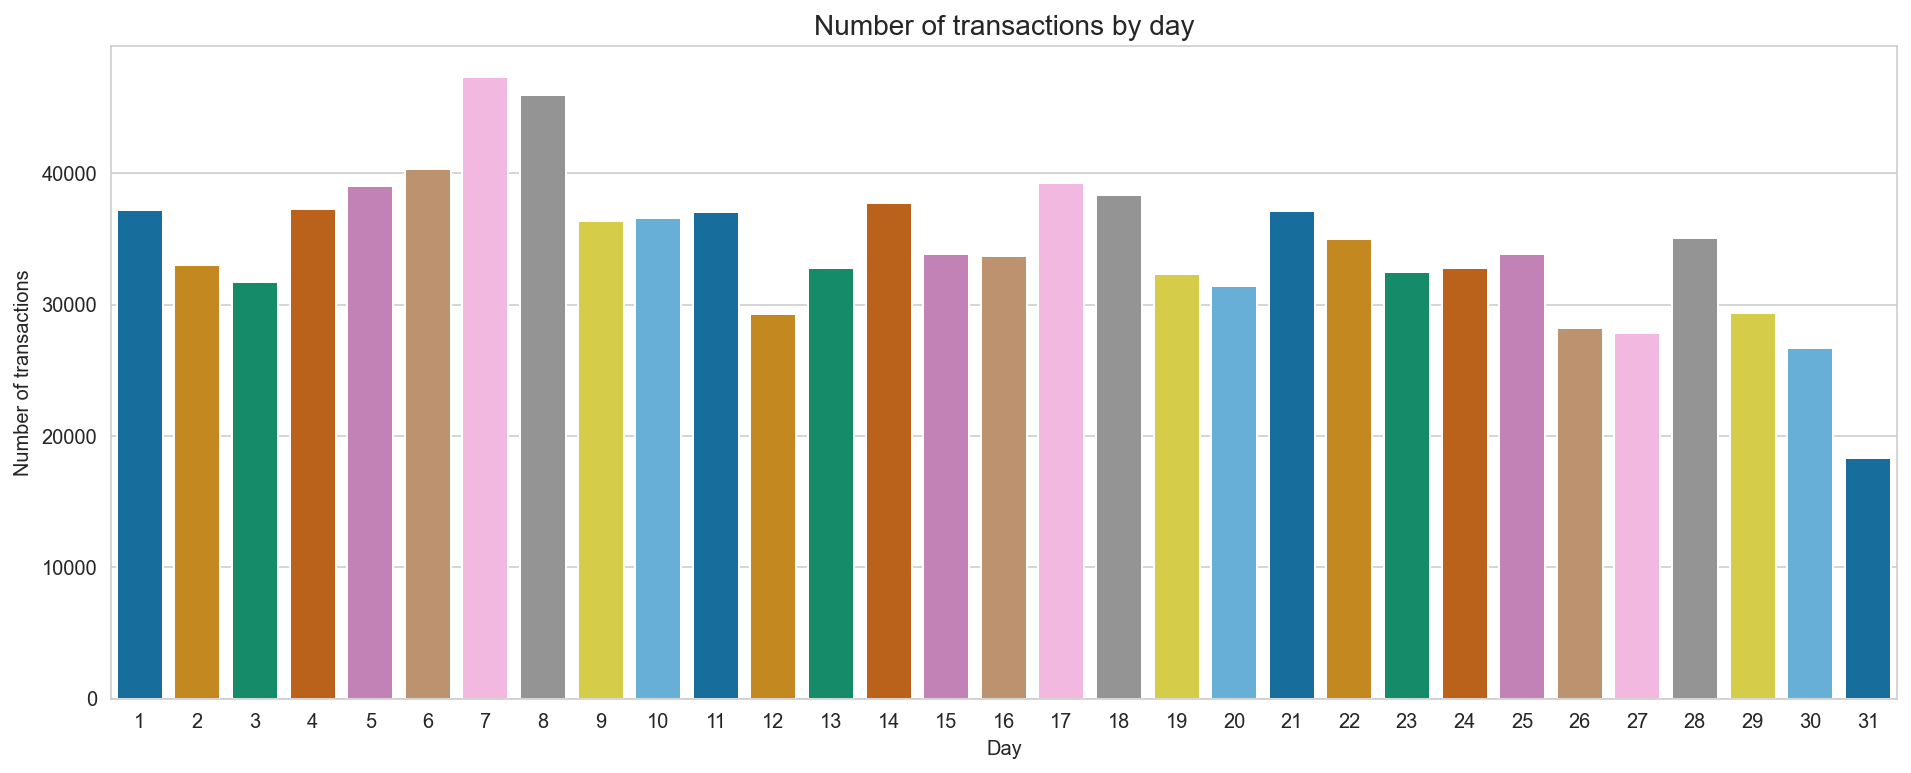

In [35]:
# view the distribution of transaction by 'invoice_day'
view_trans_dist(plot_x='invoice_day', plot_title='Number of transactions by day', plot_xlabel='Day')

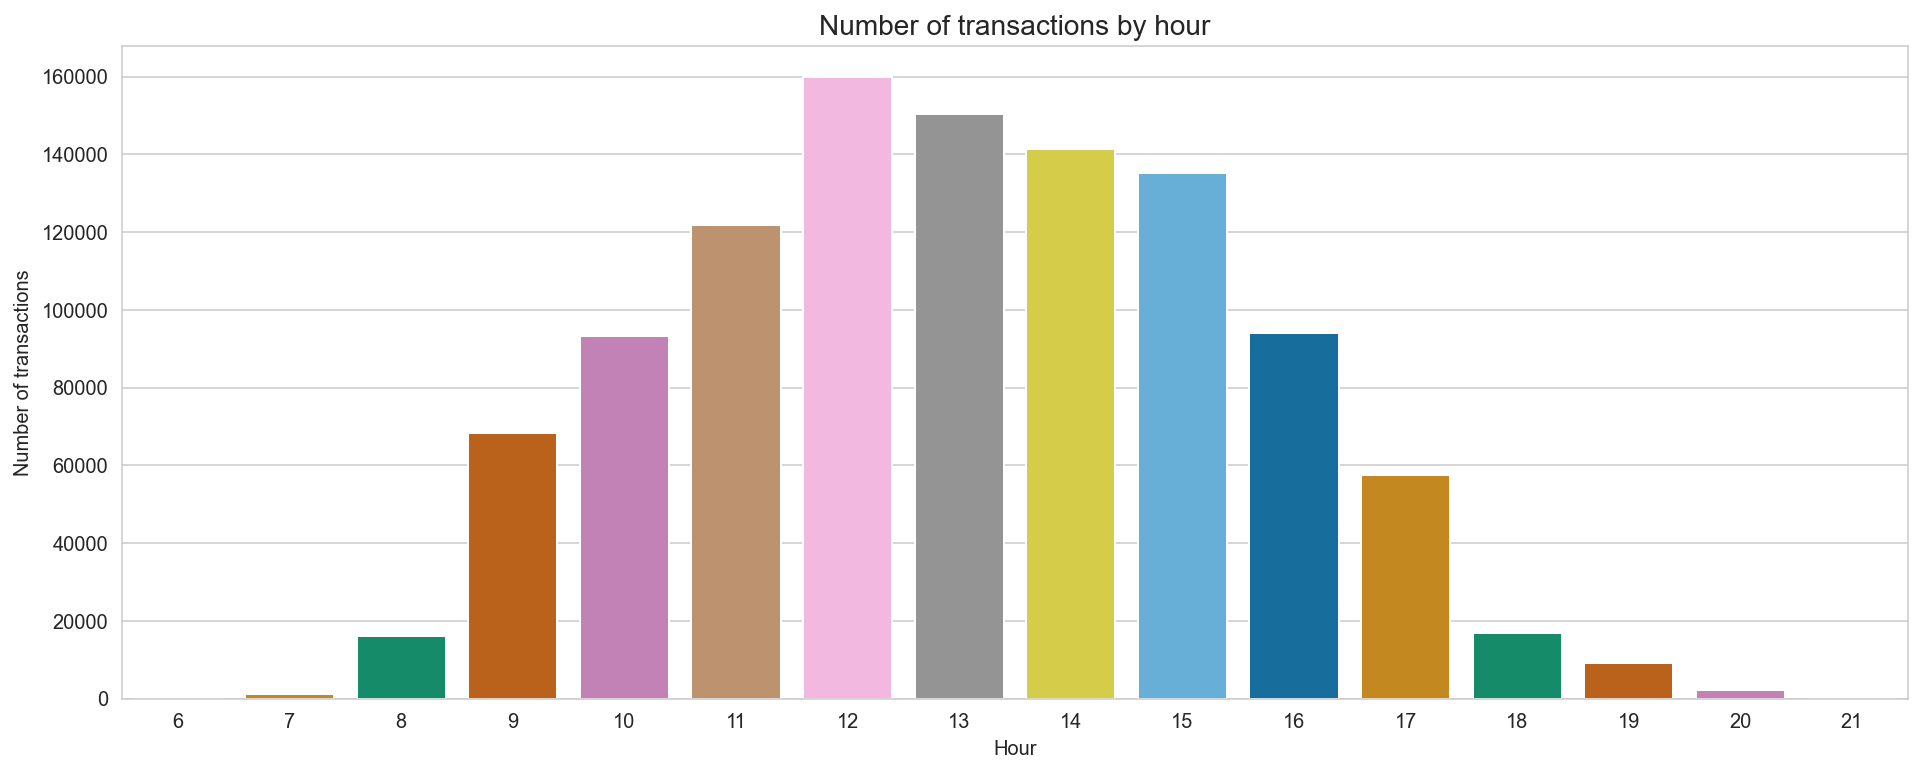

In [36]:
# view the distribution of transaction by 'invoice_hour'
view_trans_dist(plot_x='invoice_hour', plot_title='Number of transactions by hour', plot_xlabel='Hour')

Based on these visualisations, it is interesting to note that: 
- The number of transactions made in the years 2010 and 2011 are relatively on par, considering that year 2011 is missing around 20 days of transactions.
- November (represented by month '11') seems to have the most number of transactions, followed by December ('12') and October ('10'), likely contributed by the fact that there are more events, occasions happening towards the end of the year.
- There seems to be the most number of transactions recorded on the 7th day of the month, followed by 8th and 6th days.
- Most transactions seem to occur around noon time, i.e. 12pm to 3pm. 


Now that we have conducted an Exploratory Data Analysis and gained a better understanding of the dataset, let's move on to preprocess the data and create new features to prepare them for data modelling.

### 3. Data Preprocessing

#### 3.1. Preparing the data

Since there are missing values in the `Customer ID`, let's drop these null values. 

In [37]:
# drop rows with null values in 'Customer ID'
new_df = df[df['Customer ID'].notna()]

# view top 5 rows
new_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans,stockcode_length,invoicedate_only,invoice_day,invoice_month,invoice_year,invoice_hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,False,5,2009-12-01,1,12,2009,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,6,2009-12-01,1,12,2009,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,6,2009-12-01,1,12,2009,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,False,5,2009-12-01,1,12,2009,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,False,5,2009-12-01,1,12,2009,7


Let's check if there are still negative values in `Price`.

In [38]:
# check if negative values exist in 'Price'
new_df[new_df['Price']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans,stockcode_length,invoicedate_only,invoice_day,invoice_month,invoice_year,invoice_hour


Great! We have removed rows with negative values in `Price`.

Let's drop duplicated rows based on all columns. 

In [39]:
# drop duplicated rows based on all columns
new_df.drop_duplicates()

# reset index
new_df = new_df.reset_index(drop=True)

# view shape 
print(f'There are now {new_df.shape[0]} rows and {new_df.shape[1]} columns in the dataset.')

There are now 824364 rows and 15 columns in the dataset.


#### 3.2. Feature Engineering

Let's create new features that can be incorporated into the prediction of CLV.

The first of which is `total_sales`, which essentially records the total monetary value spent by customers in the particular transaction. 

In [40]:
# create new feature called 'total_sales'
new_df['total_sales'] = new_df['Quantity'] * new_df['Price']

In [42]:
# view numerical description of 'total_sales'
new_df['total_sales'].describe()

count    824364.000000
mean         20.195317
std         308.685001
min     -168469.600000
25%           4.250000
50%          11.250000
75%          19.500000
max      168469.600000
Name: total_sales, dtype: float64

<AxesSubplot:title={'center':'Distribution of total sales value overtime'}, xlabel='total_sales'>

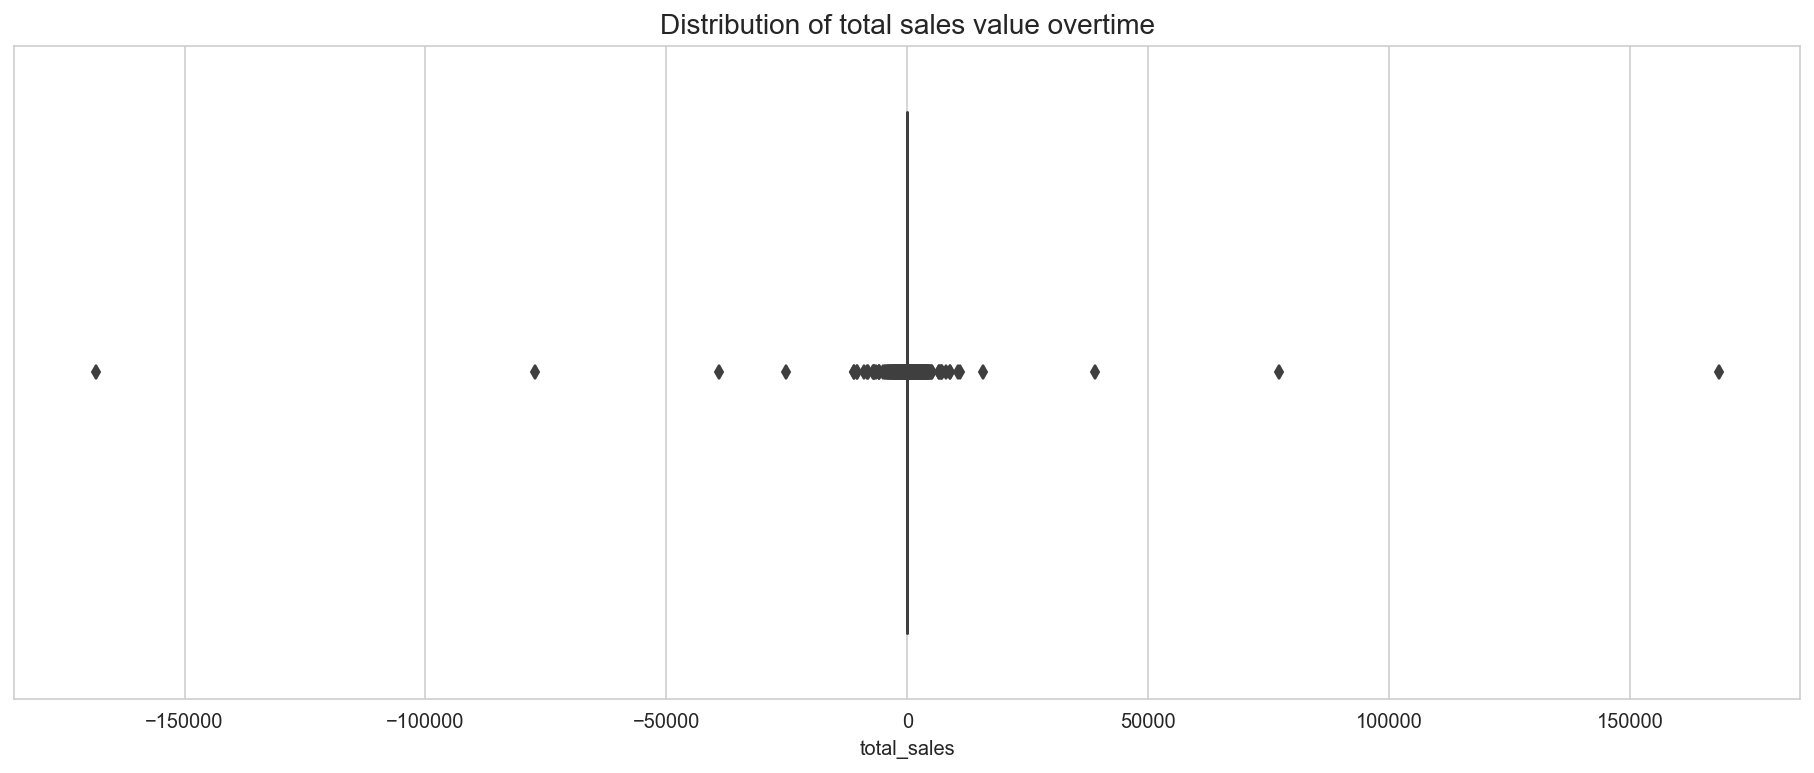

In [41]:
# view distribution of 'total_sales'
plt.figure(figsize=(16,6))
plt.title('Distribution of total sales value overtime', fontsize=14)
sns.boxplot(new_df['total_sales'])

It is interesting to note that while the mean `total_sales` is ~£20.20 and median `total_sales` is ~£11.25, multiple outliers exist, with max `total_sales` going up to £168,470 and min `total_sales` amount to -£168,470 *(likely a cancellation)*.

Let's take a look at rows with `total_sales` greater than ~£25,000, as well as those less than -£25,000.

In [46]:
# view rows with 'total_sales' > 25,000 or 'total_sales' < -£25,000
new_df[(new_df['total_sales']>25000)|(new_df['total_sales']<-25000)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancelled_trans,stockcode_length,invoicedate_only,invoice_day,invoice_month,invoice_year,invoice_hour,total_sales
188812,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom,True,1,2010-06-17,17,6,2010,16,-25111.09
455654,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,False,5,2011-01-18,18,1,2011,10,77183.60
455659,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,True,5,2011-01-18,18,1,2011,10,-77183.60
576764,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,False,5,2011-06-10,10,6,2011,15,38970.00
576774,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,True,1,2011-06-10,10,6,2011,15,-38970.00
823883,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,False,5,2011-12-09,9,12,2011,9,168469.60
823884,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,True,5,2011-12-09,9,12,2011,9,-168469.60


By looking into the transactions with `total_sales` greater than £25,000 or less than -£25,000, whenever a purchase transaction is made, there will be a corresponding cancellation transaction that happens on the same transaction day.

When computing CLV, it will make sense to include the cancellation transactions, so as to arrive at the most appropriate sales value earned from each customer while eliminating outliers present in the dataset.

In [49]:
# create a new df with just 'Customer ID' and 'total_sales'
sales_df = new_df[['Customer ID','total_sales']]

# group by 'Customer ID' and sum up 'total_sales'
sales_df = sales_df.groupby('Customer ID')['total_sales'].sum().reset_index(name='total_sales')

In [50]:
# identify top 20 customers
top20_customers_sales = sales_df.sort_values(by='total_sales',ascending=False).head(20)
top20_customers_sales

,Customer ID,total_sales
5756,18102.0,598215.22
2300,14646.0,523342.07
1810,14156.0,296564.69
2565,14911.0,270248.53
5104,17450.0,233579.39
1348,13694.0,190825.52
5165,17511.0,171885.98
69,12415.0,143269.29
4338,16684.0,141502.25
2715,15061.0,136391.48


[Text(0.5, 0, 'Customers'), Text(0, 0.5, 'Total Sales Value')]

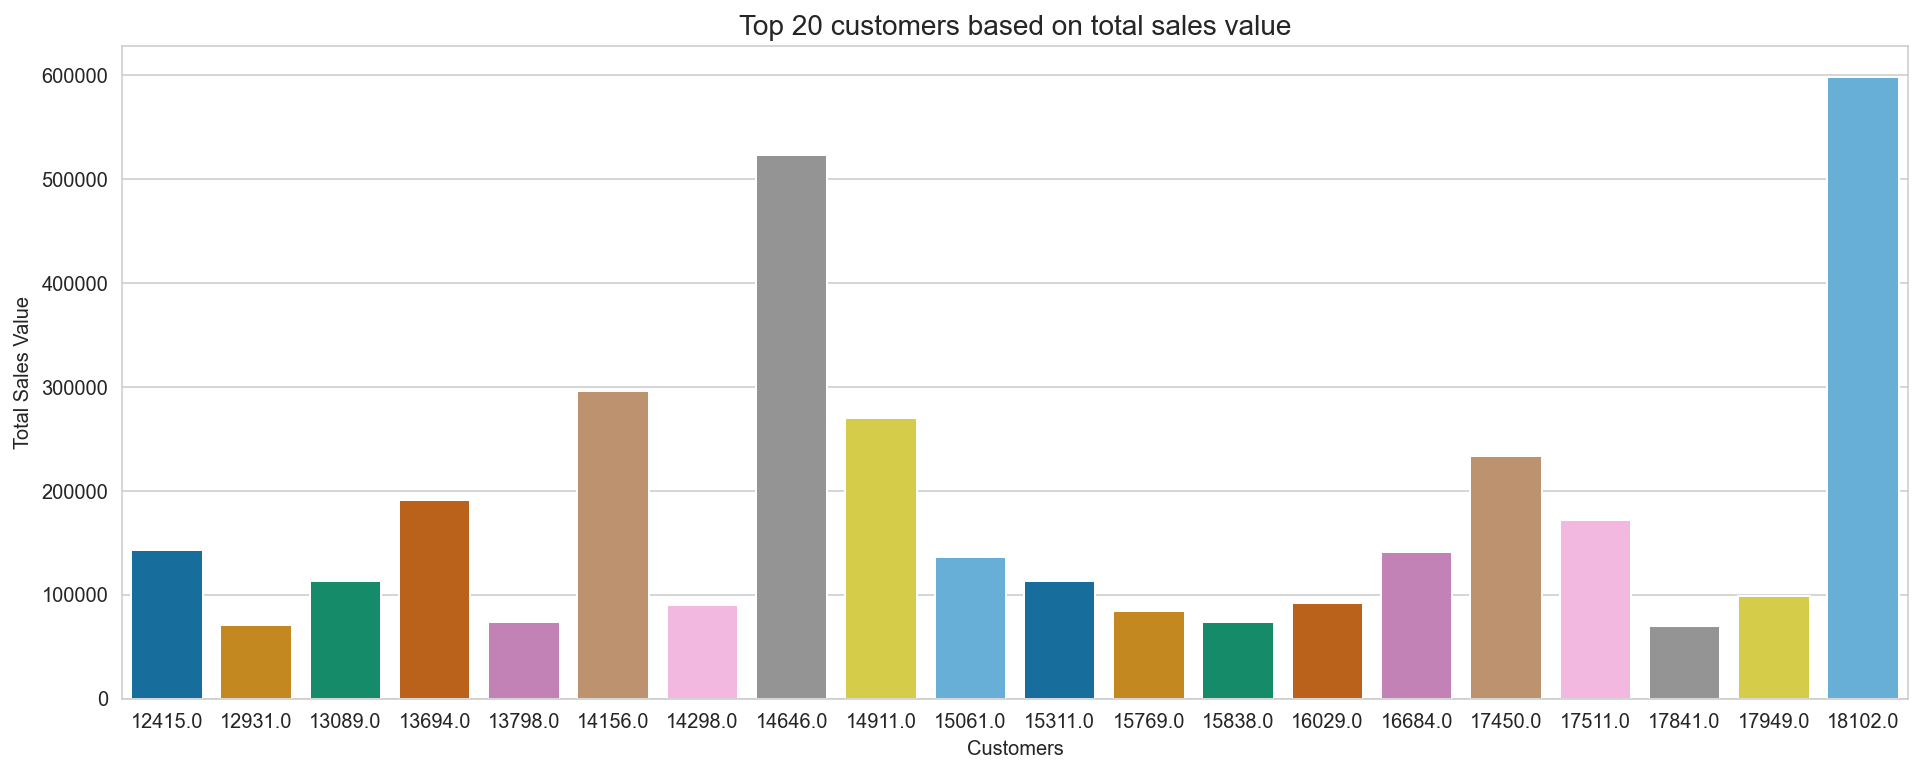

In [52]:
# plot top 20 customers based on sales
plt.figure(figsize=(16,6))
plt.title('Top 20 customers based on total sales value', fontsize=14)
ax = sns.barplot(x='Customer ID', y='total_sales', data=top20_customers_sales, palette='colorblind')
ax.set(xlabel='Customers', ylabel='Total Sales Value')

As compared to the earlier visualisation where the top 20 customers are identified based on the number of transactions made, the top 20 customers identified based on total sales value seem to differ, considering that purchase amounts have been netted off by cancellation amounts. 

### 4. Modelling

#### 4.1. Aggregate Model

#### 4.2. Cohort Model